In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import WindPy as w
from WindPy import *
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
class Data(object):

    def __init__(self, start = "2016-01-01", end = "2016-12-31"):
        self.start = start
        self.end = end
        self.hs300_stocks_list = list(w.wset(
            "sectorconstituent", 
            "date="+self.end+";windcode=000300.SH", 
            usedf = True
        )[1]['wind_code'])[:6] # only for testing

    def get_data(self):
        data = pd.DataFrame()
        for stock in self.hs300_stocks_list:
            stock_data = w.wsd(
                stock, 
                "sec_name,trade_code,pct_chg,ev,pb,beta_24m", 
                self.start, 
                self.end, 
                "unit=1;ruleType=3;period=2;returnType=1;index=000001.SH;Period=M", 
                usedf = True
            )[1]
            stock_data.index = pd.to_datetime(stock_data.index)
            stock_data.set_index(['TRADE_CODE', stock_data.index], inplace = True)
            data = data.append(stock_data)
        data.index.names = ["Code", "Date"]
        data.columns = ["Name", "Return(%)", "ME", "PB", "Beta"]
        return data

    def get_hs300(self):
        hs300 = w.wsd(
            "000300.SH", 
            "pct_chg", 
            self.start, 
            self.end, 
            "Period=M", 
            usedf = True
        )[1]
        hs300.index = pd.to_datetime(hs300.index)
        hs300.index.name = "Date"
        hs300.columns = ["Return(%)"]
        return hs300
    
    def get_months_list(self, string = True):
        months_list = w.tdays(self.start, self.end, "Period=M").Data[0]
        if string == False:
            return months_list
        else:
            return [x.strftime('%Y-%m') for x in months_list]

    def get_shibor(self):
        # wind shibor only starts from 2015-12-08. 
        shibor = w.edb(
            "M0017138", 
            self.start, 
            self.end, 
            "Fill=Previous", 
            usedf = True
        )[1]
        shibor.index = pd.to_datetime(shibor.index).strftime('%Y-%m')
        shibor = pd.DataFrame(
            shibor.groupby(shibor.index)["CLOSE"].mean()
        ).iloc[:-1, ] # it's weird, always have one extra date. 
        shibor.columns = ["SHIBOR"]
        return shibor

In [3]:
def quartile(data, factor):
    sort = data.sort_values(by = factor)
    length = round(len(sort)/4)
    low = sort[:length]
    medium = sort[length:-length]
    high = sort[-length:]
    return low, medium, high

In [4]:
def get_monthly_data(data, month):
    return data[data.index.get_level_values('Date').strftime('%Y-%m') == month]

In [14]:
class FamaFrench(Data):

    def __init__(self, start = "2016-01-01", end = "2016-12-31", excess_return = True):
        super(FamaFrench, self).__init__(start, end)
        self.data = Data(start, end).get_data()
        self.hs300 = Data(start, end).get_hs300()
        self.months_list = Data(start, end).get_months_list()
        self.excess_return = excess_return
        self.SHIBOR = list(Data(start, end).get_shibor()["SHIBOR"])
        
    def beta(self):
        beta = self.hs300
        beta.index = self.months_list
        beta.columns = ["Return(%)"]
        if self.excess_return:
            beta['SHIBOR'] = self.SHIBOR
            beta["Excess Return(%)"] = beta["Return(%)"] - beta["SHIBOR"]
        else:
            pass
        return beta

    def SMB(self):
        SMB_list = []
        for month in self.months_list:
            monthly_data = get_monthly_data(self.data, month)
            small_ME = quartile(monthly_data, 'ME')[0]
            big_ME = quartile(monthly_data, 'ME')[2]
            small_ME_return = small_ME.sum(axis = 0)["Return(%)"]/len(small_ME)
            big_ME_return = big_ME.sum(axis = 0)["Return(%)"]/len(big_ME)
            SMB_list.append(small_ME_return - big_ME_return)
        SMB = pd.DataFrame(
            SMB_list, 
            index = self.months_list, 
            columns = ["Return(%)"]
        )
        if self.excess_return:
            SMB['SHIBOR'] = self.SHIBOR
            SMB["Excess Return(%)"] = SMB["Return(%)"] - SMB["SHIBOR"]
        else:
            pass
        return SMB

    def HML(self):
        HML_list = []
        for month in self.months_list:
            monthly_data = get_monthly_data(self.data, month)
            small_PB = quartile(monthly_data, 'PB')[0]
            big_PB = quartile(monthly_data, 'PB')[2]
            small_PB_return = small_PB.sum(axis = 0)["Return(%)"]/len(small_PB)
            big_PB_return = big_PB.sum(axis = 0)["Return(%)"]/len(big_PB)
            HML_list.append(small_PB_return - big_PB_return)
        HML = pd.DataFrame(
            HML_list, 
            index = self.months_list, 
            columns = ["Return(%)"]
        )
        if self.excess_return:
            HML['SHIBOR'] = self.SHIBOR
            HML["Excess Return(%)"] = HML["Return(%)"] - HML["SHIBOR"]
        else:
            pass
        return HML

    def y(self, code = '000001'):
        y = pd.DataFrame(Data(self.start, self.end).get_data().loc[code]["Return(%)"])
        y["SHIBOR"] = self.SHIBOR
        y["Excess Return(%)"] = y["Return(%)"] - y["SHIBOR"]
        return y

    def get_data(self):
        data = pd.DataFrame(
            index = self.months_list, 
            columns = ["Stock", "Market", "SMB", "HML"]
        )
        data["Stock"] = list(FamaFrench(self.start, self.end).y()["Excess Return(%)"])
        data["Market"] = list(FamaFrench(self.start, self.end).beta()["Excess Return(%)"])
        data["SMB"] = list(FamaFrench(self.start, self.end).SMB()["Excess Return(%)"])
        data["HML"] = list(FamaFrench(self.start, self.end).HML()["Excess Return(%)"])
        return data

In [15]:
FF = FamaFrench(
    start = "2016-01-01", 
    end = "2017-12-31", 
    excess_return = True
)

In [16]:
data = FF.get_data()

y = list(data["Stock"])
x = data.loc[:, ["Market", "SMB", "HML"]]
x = sm.add_constant(x)
model = sm.OLS(y, x)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     8.158
Date:                Fri, 07 Dec 2018   Prob (F-statistic):           0.000962
Time:                        16:20:53   Log-Likelihood:                -69.378
No. Observations:                  24   AIC:                             146.8
Df Residuals:                      20   BIC:                             151.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0672      1.314      0.812      0.4

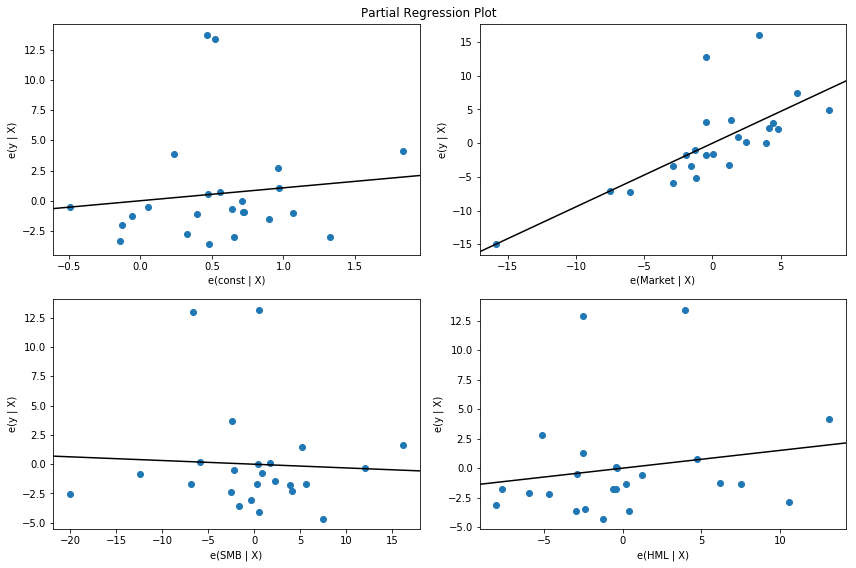

In [17]:
fig = plt.figure(figsize = (12, 8))
fig = sm.graphics.plot_partregress_grid(result, fig = fig)

C:\Users\KasperLin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


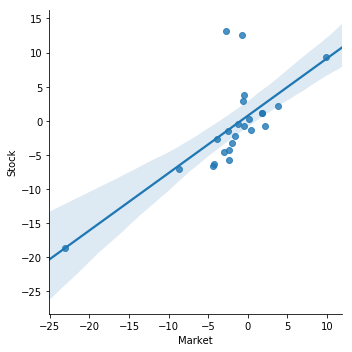

In [18]:
sns.lmplot(x = "Market", y = "Stock", data = data)